In [3]:
# Basic libraries
import pandas as pd 
import numpy as np
import re

# Visualisation libraries
import matplotlib.pyplot as plt 
import seaborn as sns


# Modelling libraries
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib_venn import venn2_unweighted

# Set styles and display options
pd.options.display.precision = 4

In [4]:
# Functions
def farenheit_to_celsius(farenheit):
  return ((farenheit - 32) * (5/9))

def m_to_km(m):
  return (m*1.609344)

def in_to_mm(i):
  return (i*25.4)

# Function to retrieve performance metrics
def scores(name, y_test, y_pred):
        list = [name,
                precision_score(y_test, y_pred, average='weighted'),
                recall_score(y_test, y_pred, average='weighted'),
                f1_score(y_test, y_pred, average='weighted'),
                accuracy_score(y_test, y_pred)]
        return list

In [5]:
# Load data
# ny = pd.read_csv('ny_accidents.csv')

# Import data for Google Collab. Remove before submission
url = 'https://raw.githubusercontent.com/aqualytics/INFT6201-Assignment3/main/ny_accidents.csv?token=GHSAT0AAAAAABZNNFLGDHXVZMJZZRLCVUMQYZXUG3Q'
df = pd.read_csv(url)

# Drop columns that won't be used in the analysis
try: # remove exception handling before submission
  cols = ['Unnamed: 0','Number', 'Airport_Code', 'Timezone', 'Country', 'State', 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Turning_Loop']
  df.drop(cols, axis=1, inplace=True)
except:
  pass

# Drop duplicates
df.drop_duplicates()

# Drop rows with na values
df.dropna(inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36779 entries, 0 to 39536
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 36779 non-null  object 
 1   Severity           36779 non-null  int64  
 2   Start_Time         36779 non-null  object 
 3   End_Time           36779 non-null  object 
 4   Start_Lat          36779 non-null  float64
 5   Start_Lng          36779 non-null  float64
 6   End_Lat            36779 non-null  float64
 7   End_Lng            36779 non-null  float64
 8   Distance.mi.       36779 non-null  float64
 9   Description        36779 non-null  object 
 10  Street             36779 non-null  object 
 11  Side               36779 non-null  object 
 12  City               36779 non-null  object 
 13  County             36779 non-null  object 
 14  Zipcode            36779 non-null  object 
 15  Weather_Timestamp  36779 non-null  object 
 16  Temperature.F.     367

In [10]:
# Pre-process of data
# Rename columns 
df.rename(columns = {'Distance.mi.':'Distance',
                     'Wind_Speed.mph.':'Wind_Speed',
                     'Temperature.F.':'Temperature',
                     'Wind_Chill.F.':'Wind_Chill',
                     'Humidity...':'Humidity',
                     'Pressure.in.':'Pressure',
                     'Visibility.mi.':'Visibility',
                     'Precipitation.in.':'Precipitation'}, inplace=True)

## Variable groups as lists
weather = ['Weather_Timestamp', 'Temperature', 'Wind_Chill', 'Humidity', 'Pressure','Visibility','Wind_Direction','Wind_Speed','Precipitation','Weather_Condition']
poi = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming_ex_Bump','Traffic_Signal']

# Convert dates & times to datetime type
cols = ['Start_Time','End_Time','Weather_Timestamp']
df[cols] = df[cols].apply(pd.to_datetime, errors='coerce')

# Convert imperial units to metric
df[['Temperature', 'Wind_Chill']] = df[['Temperature', 'Wind_Chill']].apply(farenheit_to_celsius) # farenheit to celsius
df[['Visibility', 'Wind_Speed']] = df[['Visibility', 'Wind_Speed']].apply(m_to_km) # miles to kilometres
df['Precipitation'] = df['Precipitation'].apply(in_to_mm) # inches to mm

# Add severity_cat column
conditions  = [ df['Severity'] == 1, df['Severity'] == 2, df['Severity'] == 3, df['Severity'] == 4 ]
choices     = [ 'Low','Medium','High','Very High']
df['severitycat'] = np.select(conditions, choices, default=np.nan)

# Add highway column
keywords = ['Pkwy', 'Parkway', 'I-', 'Interstate', 'Expy', 'Exp', 'Expressway', 'Route', 'State', 'NY', 'Trwy', 'Thoughway', 'US', 'Hwy', 'Highway', 'Wyck', '9n']
df['Highway'] = False #where False = other
df.loc[df['Street'].str.contains('|'.join(keywords), case = False) == True, 'Highway'] = True #where True = Highway

# Add weather_cat column to consolidate weather conditions
conditions = [df['Weather_Condition'].str.contains('Clear|Fair', case=False) == True,
              df['Weather_Condition'].str.contains('Cloud|Overcast', case=False) == True,
              df['Weather_Condition'].str.contains('Rain|Storm', case=False) == True,
              df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False) == True,
              df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False) == True,
              df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', flags=re.IGNORECASE, regex=True) == True,
              df['Weather_Condition'].str.contains('Fog', case=False) == True]
choices = ['Clear', 'Cloud', 'Rain', 'Heavy_rain', 'Snow', 'Heavy_Snow','Fog']
df['Weather_Condition'] = np.select(conditions, choices, default='Other') # Assign null value as clear

# Clean wind direction
df['Wind_Direction'].replace({'North':'N','West':'W','East':'E','Variable':'VAR','South':'S'}, inplace=True)


# Add season category
df['month'] = df['Start_Time'].dt.month
conditions = (df.month < 3, df.month < 5, df.month < 8, df.month <12, df.month == 12)
choices = ['winter', 'spring','summer', 'fall', 'winter']
df['season'] = np.select(conditions, choices, default=np.nan)
df.drop('month', axis=1, inplace=True)

# Add weekday
df['weekday'] = df['Start_Time'].dt.dayofweek

# Add month
df['month'] = df['Start_Time'].dt.month

# Add year
df['year'] = df['Start_Time'].dt.year

# Add incident duration
df['duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds().div(60).astype(int)

## Convert poi from Boolean values True/False into 1/0
df['Traffic_Calming_ex_Bump'] = df['Traffic_Calming']
df['Traffic_Calming_ex_Bump'] = np.where(df.Bump == True, False, df['Traffic_Calming_ex_Bump'])

<AxesSubplot:xlabel='Severity', ylabel='Ratio'>

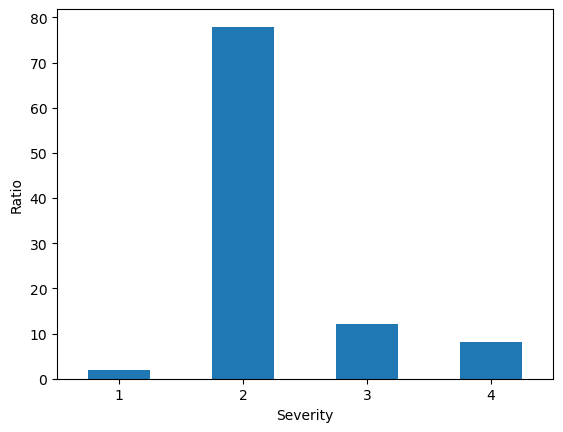

In [7]:
# Summarise Severity category
severity_prop = pd.DataFrame()
severity_prop['count'] = df['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', xlabel='Severity', ylabel='Ratio', rot=0)

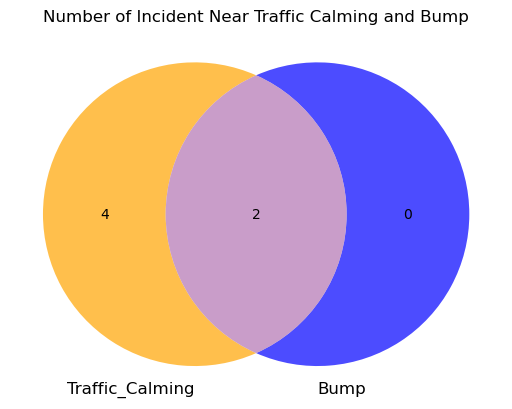

Mean of Severity for each Subset:


count  mean
Traffic_Calming Bump              
True            False      4   2.0
                True       2   4.0

Mean of Severity for all observations: 2.26


In [8]:
## poi: Traffic_Calming vs Bump (justification to create Variable Traffic_Calming_ex_Bump)

## Venn Diagram: Traffic_Calming & Bump
TC = df['Traffic_Calming'].sum()
B =  df['Bump'].sum()

df['total_TC_B'] = df['Traffic_Calming'].astype(int) + df['Bump'].astype(int)
df['TC_and_B'] = pd.Series(df.total_TC_B == 2).map({True: 1, False: 0})
TC_B = TC_B = df['TC_and_B'].sum()

## Depict diagram
venn2_unweighted(subsets = (TC-TC_B, B-TC_B, TC_B),
                 set_labels = ('Traffic_Calming','Bump'),
                 set_colors=("orange","blue"),alpha=0.7)

plt.title('Number of Incident Near Traffic Calming and Bump')
plt.show()

## Show Mean of Severity
print("Mean of Severity for each Subset:")
display(df[(df.total_TC_B > 0)].groupby(['Traffic_Calming','Bump'])['Severity'].agg(['count','mean']))
print(("Mean of Severity for all observations: {:.2f}").format(df['Severity'].mean()))

In [9]:
## Summarise poi data
display(df[poi].agg(['sum']))
display(df.groupby(['Severity']).agg({'Amenity':['sum'],'Bump':['sum'],'Crossing':['sum'], 'Give_Way':['sum'], 'Junction':['sum'], 'No_Exit':['sum'], 'Railway':['sum'], 'Roundabout':['sum'], 'Station':['sum'], 'Stop':['sum'], 'Traffic_Calming_ex_Bump':['sum'], 'Traffic_Signal':['sum']}))



,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming_ex_Bump,Traffic_Signal
sum,789,2,1907,127,5613,61,270,2,626,478,4,5750


,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming_ex_Bump,Traffic_Signal
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
Severity,,,,,,,,,,,,
1,13,0,30,1,121,0,2,0,6,4,0,96
2,578,0,1410,89,4465,59,205,2,448,359,4,4158
3,124,0,293,17,685,0,25,0,79,56,0,1043
4,74,2,174,20,342,2,38,0,93,59,0,453


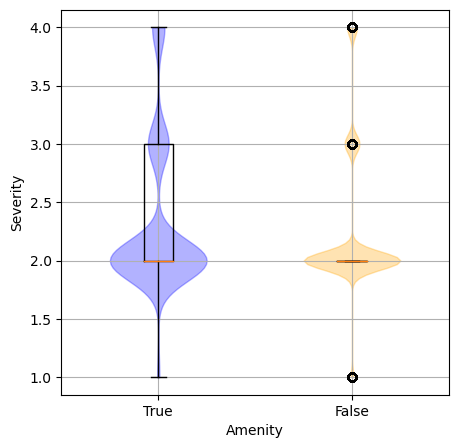

In [312]:
## Plot each variable

## Plot poi: Amenity
plotlabels = [True,False]
plotdata = [df[df['Amenity'] == label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Amenity') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

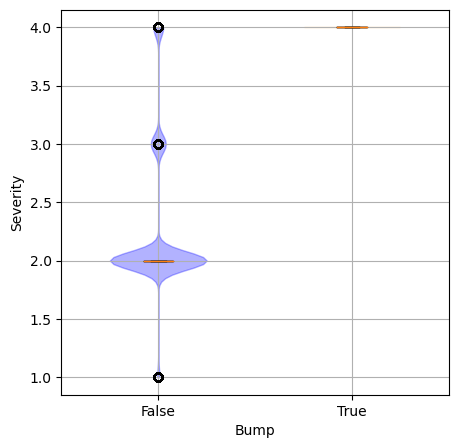

In [311]:
## Plot poi: Bump
plotlabels = [False,True]
plotdata = [df[df['Bump']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Bump') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

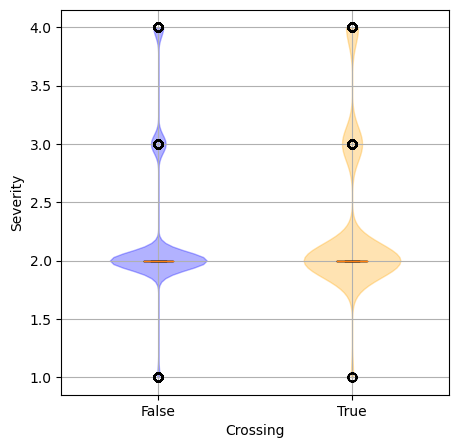

In [310]:
## Plot poi: Crossing
plotlabels = [False,True]
plotdata = [df[df['Crossing']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Crossing') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

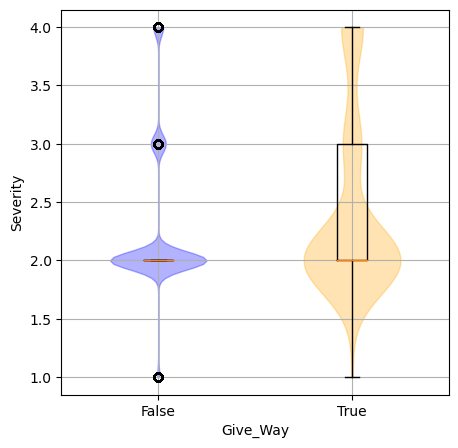

In [309]:
## Plot poi: Give_Way
plotlabels = [False,True]
plotdata = [df[df['Give_Way']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Give_Way') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()


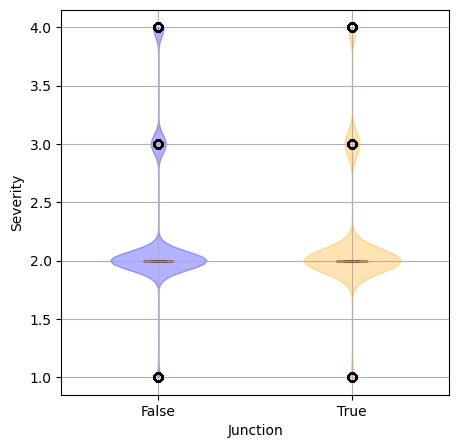

In [308]:
## Plot poi: Junction
plotlabels = [False,True]
plotdata = [df[df['Junction']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Junction') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

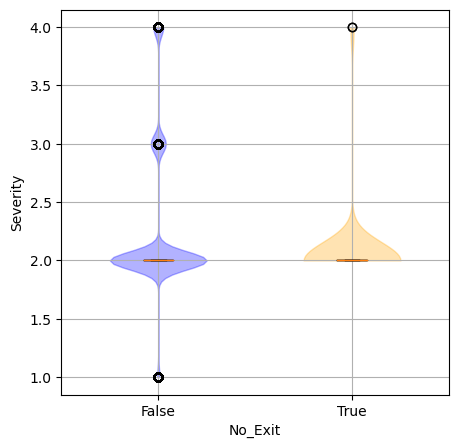

In [307]:
## Plot poi: No_Exit
plotlabels = [False,True]
plotdata = [df[df['No_Exit']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('No_Exit') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

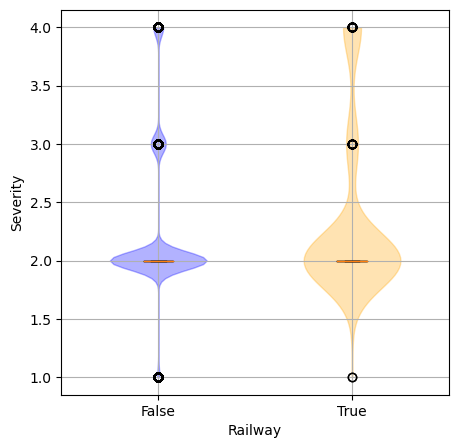

In [306]:
## Plot poi: Railway
plotlabels = [False,True]
plotdata = [df[df['Railway']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Railway') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

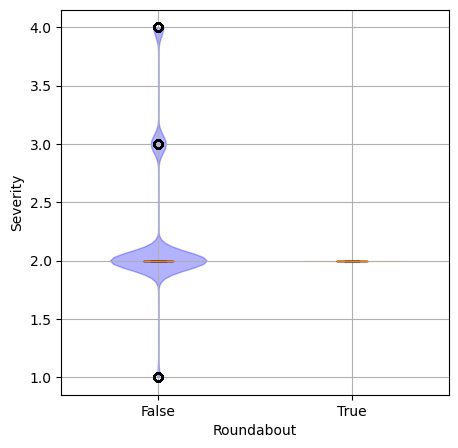

In [305]:
## Plot poi: Roundabout
plotlabels = [False,True]
plotdata = [df[df['Roundabout']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Roundabout') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

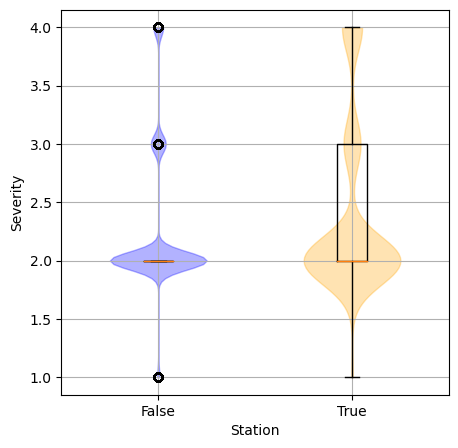

In [304]:
## Plot poi: Station
plotlabels = [False,True]
plotdata = [df[df['Station']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Station') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()


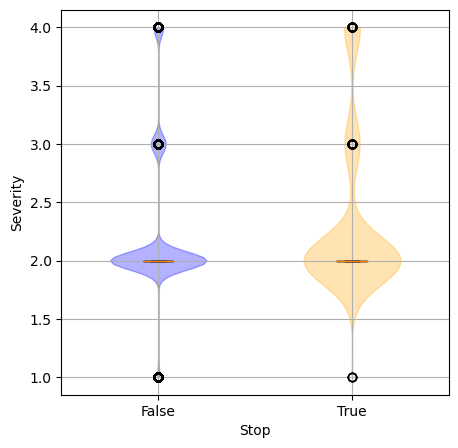

In [303]:
## Plot poi: Stop
plotlabels = [False,True]
plotdata = [df[df['Stop']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Stop') # Set x label
plt.ylabel('Severity Category (1-4)') # Set y label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

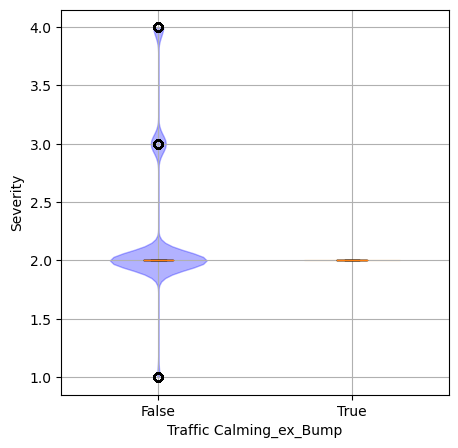

In [302]:
## Plot poi: Traffic_Calming_ex_Bump
plotlabels = [False,True]
plotdata = [df[df['Traffic_Calming_ex_Bump']==label]['Severity'] for label in plotlabels]
colors = ['blue','orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Traffic Calming_ex_Bump') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

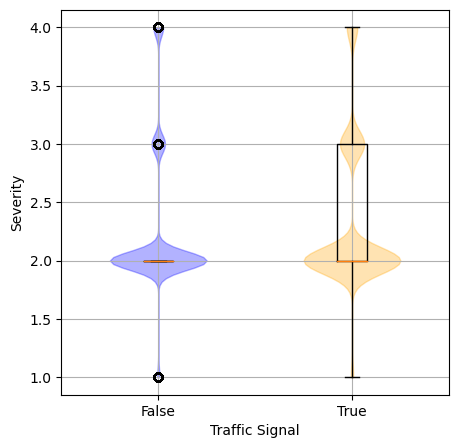

In [301]:
# Plot poi: Traffic_Signal
plotlabels = [False,True]
plotdata = [df[df['Traffic_Signal']==label]['Severity'] for label in plotlabels]
colors = ['blue', 'orange']
plt.figure(figsize=(5, 5))
vparts = plt.violinplot(plotdata, showextrema=False) # Violin plot incl. density estimation
for patch, color in zip(vparts['bodies'], colors):
    patch.set_color(color) # Set color for violin plot
plt.boxplot(plotdata, widths=0.15, zorder=3, labels=plotlabels) # Overlay box plot
plt.xlabel('Traffic Signal') # Set x label
plt.ylabel('Severity') # Set y label
plt.grid(zorder=0) # Add grid
plt.show()

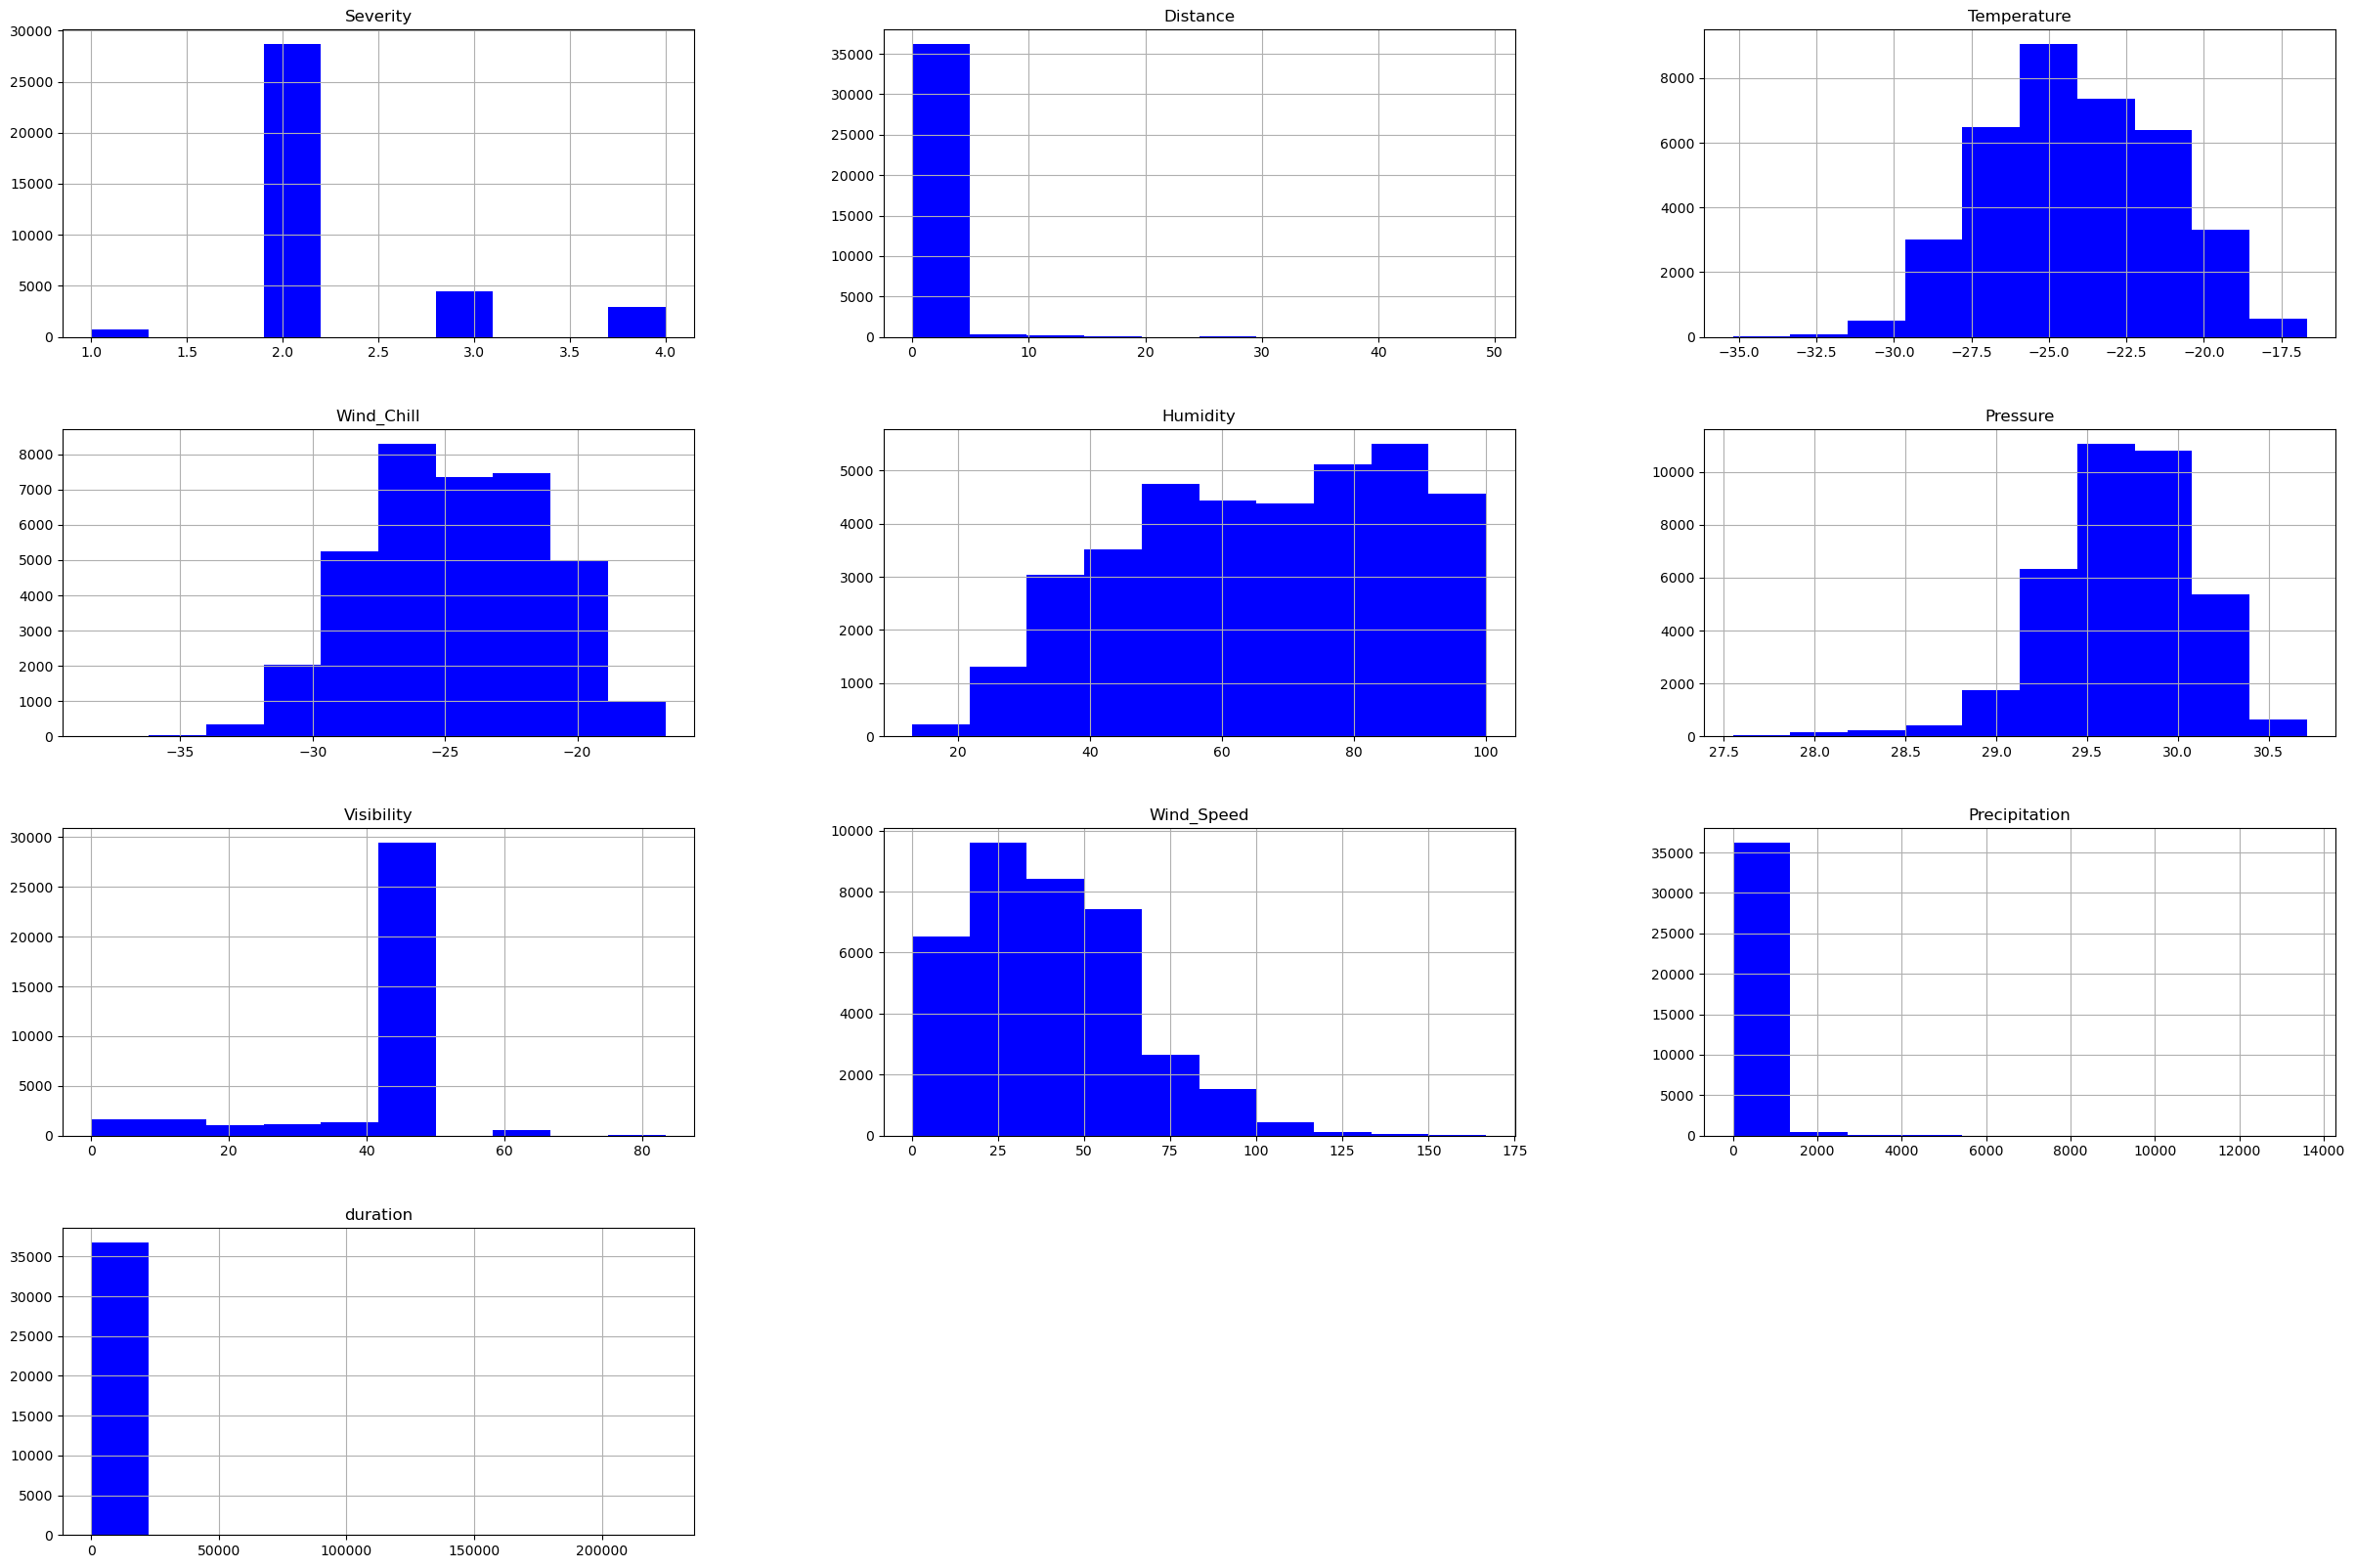

In [314]:
# Plot distribution of numeric data
numeric_cols = ['Severity', 'Distance', 'Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Visibility',
       'Wind_Speed', 'Precipitation', 'duration']
df[numeric_cols].hist(figsize=(30,20));

In [267]:
# Summarise weather data
num_weather = ['Temperature', 'Wind_Chill', 'Humidity', 'Pressure','Visibility','Wind_Speed','Precipitation'] # weather columns containing numerical variables
df_weather_stats = df[num_weather].describe().T
df_weather_stats = pd.concat([df_weather_stats, df[num_weather].skew()], axis=1).rename(columns={0:'Skewness'})
df_weather_stats = pd.concat([df_weather_stats, df[num_weather].kurt()], axis=1).rename(columns={0:'Kurtosis'})
display(df_weather_stats)



,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
Temperature,36779.0,-24.1338,2.8343,-35.1989,-26.2826,-24.2250,-21.9959,-16.6804,0.0293,-0.5393
Wind_Chill,36779.0,-24.5685,3.3050,-38.3539,-27.1399,-24.2250,-21.9959,-16.6804,-0.1464,-0.6776
Humidity,36779.0,66.1843,20.5300,13.0000,50.0000,68.0000,84.0000,100.0000,-0.2221,-0.9989
Pressure,36779.0,29.6950,0.3921,27.5500,29.4500,29.7200,29.9700,30.7100,-0.7262,1.5056
Visibility,36779.0,37.6180,11.1877,0.0000,41.6818,41.6818,41.6818,83.3636,-1.8470,3.6659
Wind_Speed,36779.0,37.8183,24.4364,0.0000,20.8409,33.3455,54.1864,166.7273,0.6788,0.7363
Precipitation,36779.0,86.4867,452.2590,0.0000,0.0000,0.0000,0.0000,13601.2631,10.2372,149.7634


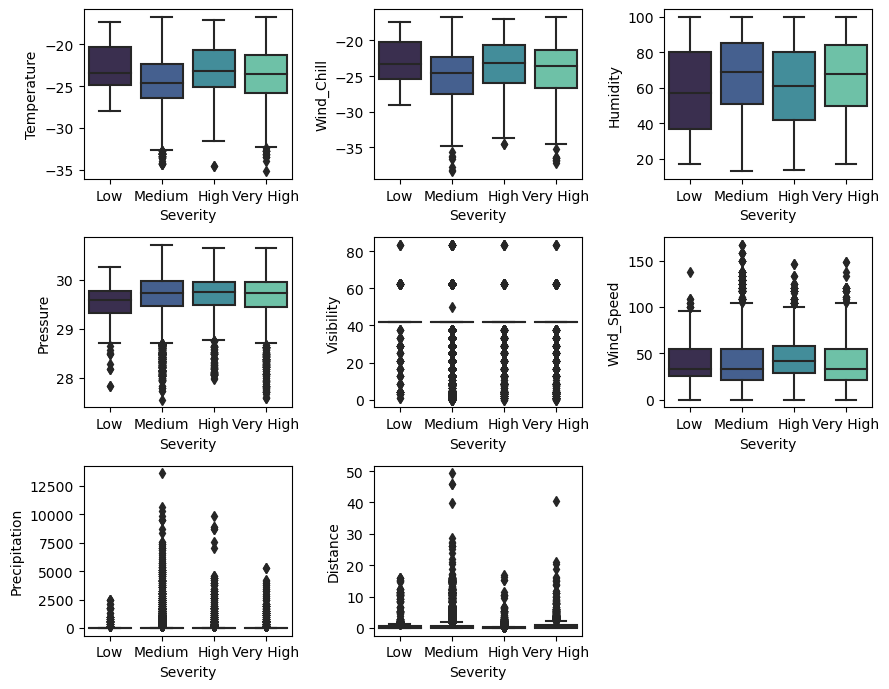

In [317]:
# Boxplot each variable
fig, ax = plt.subplots(3, 3)
fig.set_figheight(7)
fig.set_figwidth(9)
sns.boxplot(ax = ax[0, 0], x='Severity',y='Temperature', data=df, palette='mako')
sns.boxplot(ax=ax[0, 1], x='Severity',y='Wind_Chill', data=df, palette='mako')
sns.boxplot(ax= ax[0, 2], x='Severity',y='Humidity', data=df, palette='mako')
sns.boxplot(ax = ax[1, 0], x='Severity',y='Pressure', data=df, palette='mako')
sns.boxplot(ax = ax[1, 1], x='Severity',y='Visibility', data=df, palette='mako')
sns.boxplot(ax = ax[1, 2], x='Severity',y='Wind_Speed', data=df, palette='mako')
sns.boxplot(ax = ax[2, 0], x='Severity',y='Precipitation', data=df, palette='mako')
sns.boxplot(ax = ax[2, 1], x='Severity',y='Distance', data=df, palette='mako')
fig.delaxes(ax[2][2])
plt.setp(ax, xticks=[0, 1, 2, 3], xticklabels=['Low', 'Medium', 'High', 'Very High'])
fig.tight_layout()

Explore the dataset

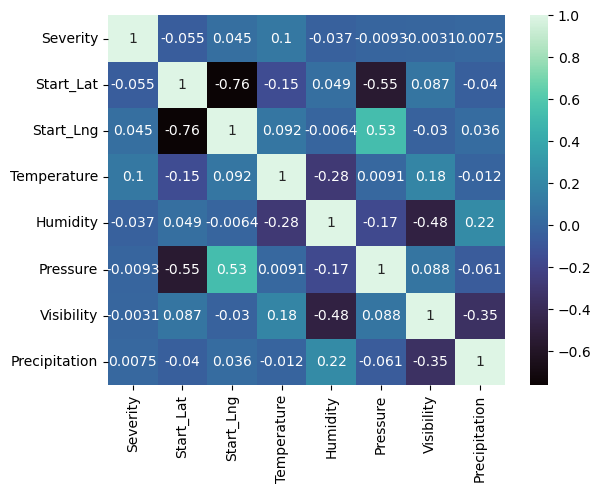

In [318]:
# Find correlations for weather features
sns.heatmap(df[['Severity','Start_Lat','Start_Lng','Temperature', 'Humidity', 'Pressure', 'Visibility','Precipitation','Weather_Condition']].corr(), cmap='mako', annot=True)
plt.show()

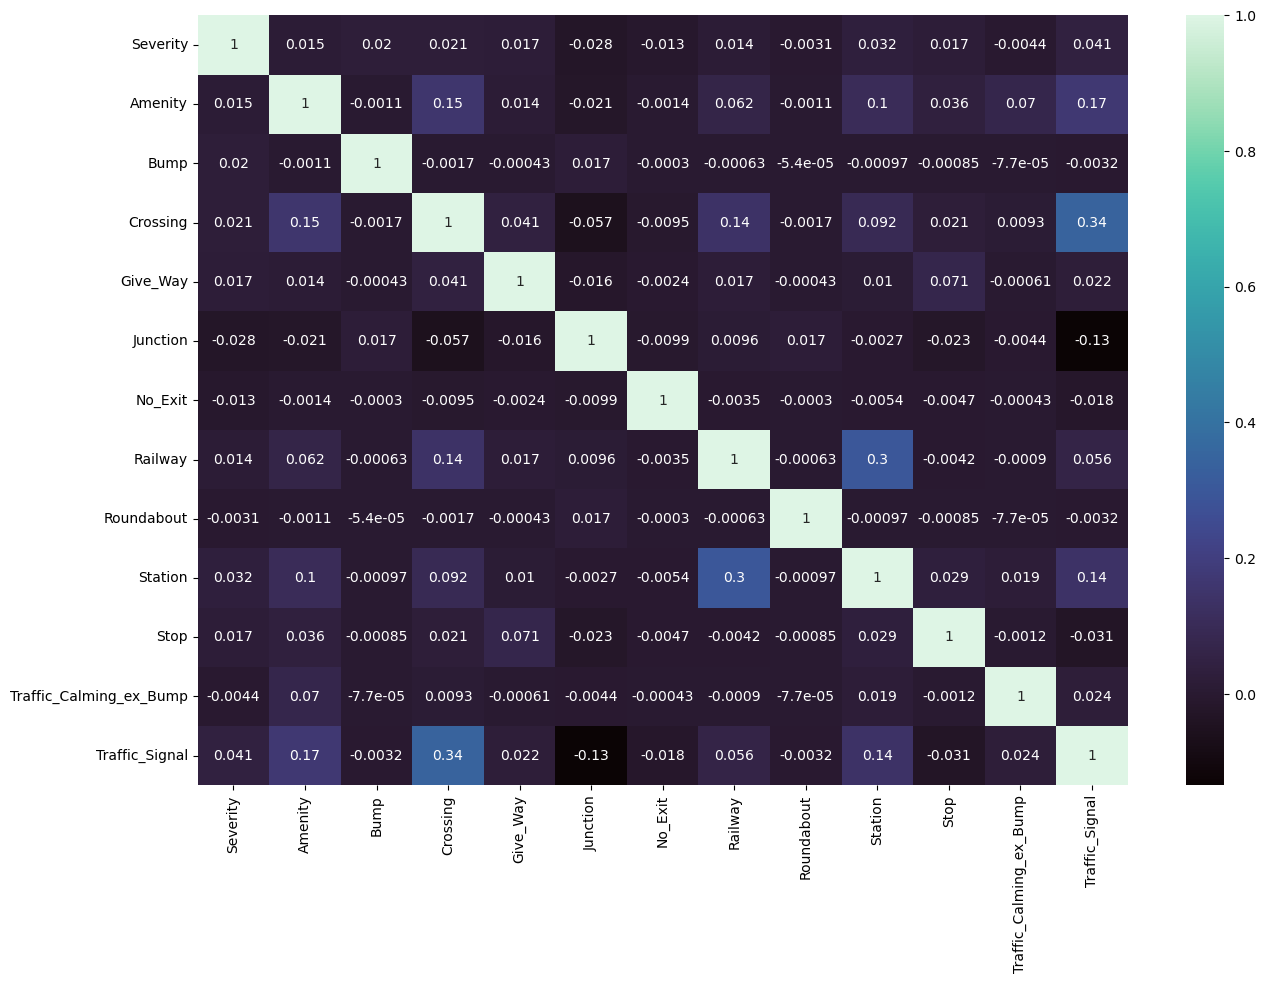

In [270]:
## Find correlations for poi features 
plt.figure(figsize=(15,10))
sns.heatmap(df[['Severity','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming_ex_Bump','Traffic_Signal']].corr(), cmap='mako', annot=True)
plt.show()

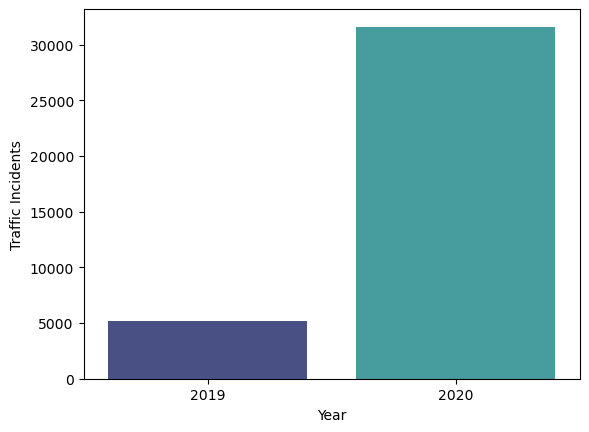

In [286]:
# Accident Severity Counts by Year
ax = sns.countplot(x='year', data=df, palette = 'mako')
ax.set(title='', xlabel="Year", ylabel="Traffic Incidents")
plt.show()

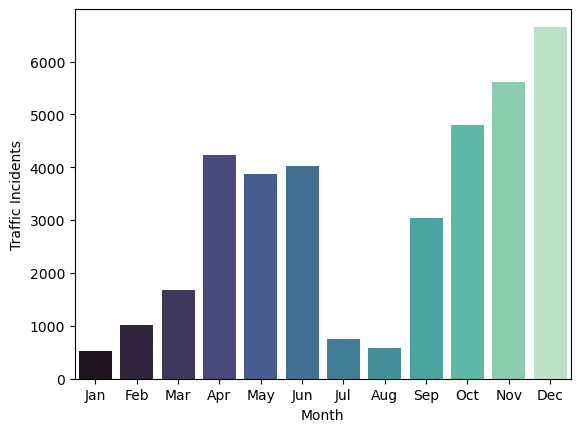

In [287]:
# Accident Severity Counts by Month
ax = sns.countplot(x='month', data=df, palette = 'mako')
ax.set(title='', xlabel="Month", ylabel="Traffic Incidents")
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

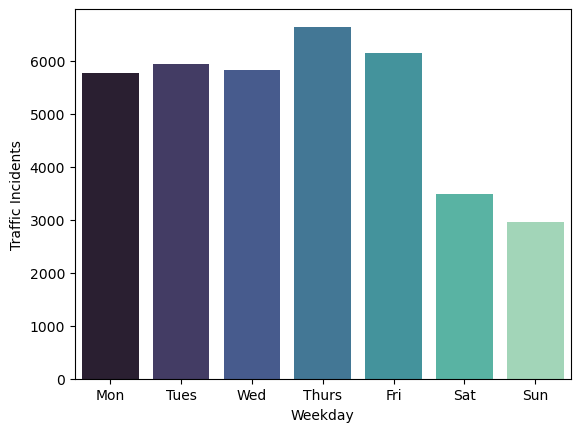

In [285]:
# Accident Severity Counts by Day of Week
ax = sns.countplot(x='weekday', data=df, palette = 'mako')
ax.set(title='', xlabel = "Weekday", ylabel="Traffic Incidents")
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs','Fri','Sat','Sun'])
plt.show()

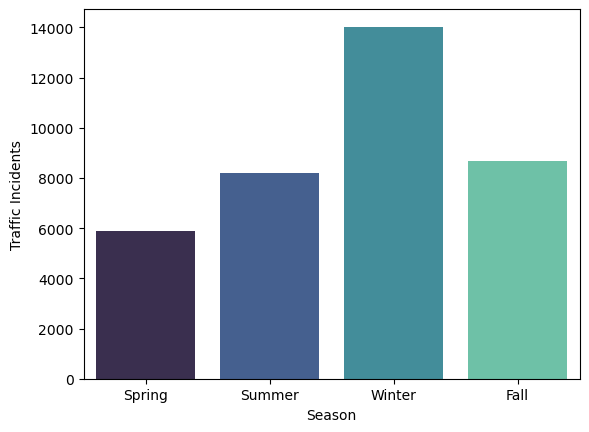

In [283]:
# Accident Severity Counts by Season
ax = sns.countplot(x='season', data=df, order = {'spring','summer','fall','winter'}, palette = 'mako')
ax.set(title='', xlabel = "Season", ylabel="Traffic Incidents")
ax.set_xticklabels(['Spring','Summer', 'Winter', 'Fall'])
plt.show()

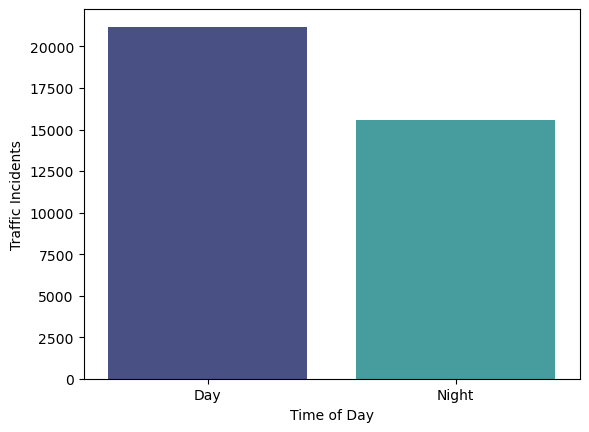

In [282]:
# Accident Severity Counts by Day/Night
ax = sns.countplot(x='Sunrise_Sunset', data=df, order={'Day', 'Night'}, palette = 'mako')
ax.set(title='', xlabel="Time of Day", ylabel="Traffic Incidents")
plt.show()

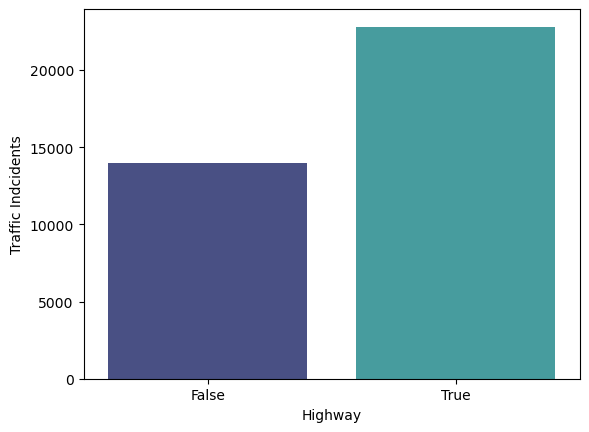

In [281]:
# Accident Severity Counts by Road Type
ax = sns.countplot(x='Highway', data=df, palette = 'mako')
ax.set(title='', xlabel="Highway", ylabel="Traffic Indcidents")
plt.show()

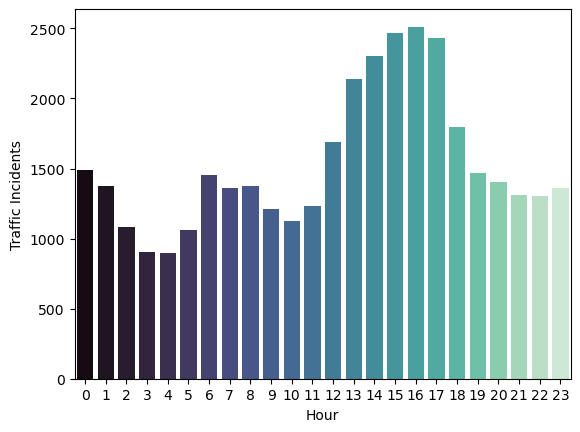

In [278]:
# Number of accidents per hour
ax = sns.countplot(x=df['Start_Time'].dt.hour, data=df, palette = 'mako')
ax.set(title='', xlabel="Hour", ylabel="Traffic Incidents")
plt.show()

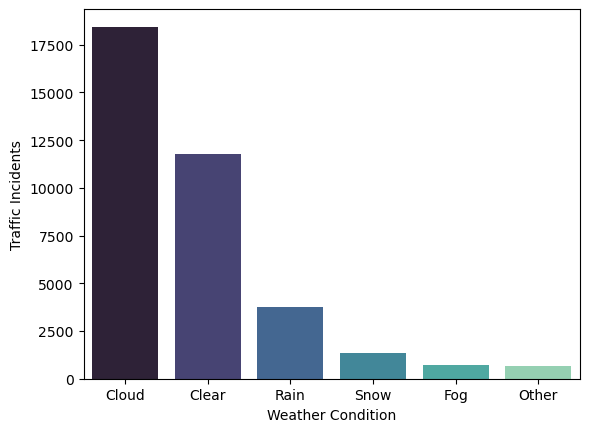

In [279]:
# Accident Severity Counts by Weather Conditions
plot_order = df.groupby('Weather_Condition')['Weather_Condition'].count().sort_values(ascending=False).index.values
ax = sns.countplot(x='Weather_Condition', data=df, order=plot_order, palette='mako')
ax.set(title='', xlabel="Weather Condition", ylabel="Traffic Incidents")
plt.show()

Classification Models to Predict Severity

In [319]:
# Prepare training and test data
exclude = ['ID', 'End_Lat','End_Lng','Start_Time', 'End_Time','Description', 'Street', 'Side','City','County','Zipcode','Weather_Timestamp', 'Wind_Direction','Severity', 'Weather_Condition', 'Sunrise_Sunset','road_type','severitycat','season','duration', 'Traffic_Calming_ex_Bump', 'total_TC_B', 'TC_and_B']
df_feat = df.copy().drop(columns = exclude)
df_target = df.Severity.copy()

# Normalise the data
cols_to_norm = ['Start_Lat', 'Start_Lng', 'Distance','Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Visibility',
       'Wind_Speed', 'Precipitation', 'weekday', 'month','year']
df_feat[cols_to_norm] = df_feat[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size = 0.3, random_state=1)

# Output size of test and training sets
print("Training set size is: ", len(X_train))
print("Test set size is: ", len(X_test))

Training set size is:  25745
Test set size is:  11034


In [320]:
# Balance training dataset
from imblearn.combine import SMOTETomek
smo_tek = SMOTETomek(random_state=1)
X_train, y_train = smo_tek.fit_resample(X_train, y_train)

# Create df to store model performance 
results = pd.DataFrame(columns = ['Model','Precision', 'Recall','F1-Score','Accuracy'])

# Output info after balancing
print("Balanced training set size is: ", len(X_train))

df = y_train.value_counts().rename_axis('Severity').reset_index(name='Count')
display(df.sort_values('Severity').style.hide(axis='index'))

Balanced training set size is:  79756


Severity,Count
1,20008
2,19892
3,19905
4,19951


In [ ]:
# Logistic regression

parameters = {
    "solver":['newton-cg'],
    "penalty":['l2'],
    "C":[0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Find the best value of n parameters for accuracy
grid = GridSearchCV(LogisticRegression(), param_grid = parameters, cv=5, scoring='f1_weighted')
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data
results.loc[len(results)] = scores('Logistic Regression', y_test, grid_predictions) # Store metrics to results df

In [ ]:
# K-Nearest Neghbours
parameters = {'n_neighbors': np.arange(1, 20)}

# Find the best value of n parameters for accuracy
grid = RandomizedSearchCV(KNeighborsClassifier(), parameters, cv = 2, random_state=1, scoring='f1_weighted')
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data
results.loc[len(results)] = scores('KNN', y_test, grid_predictions) # Store metrics to results df

In [ ]:
# SVM
# Defining parameter range for grid search
parameters ={
    "C":[0.1,1],
    "kernel":['linear'],
    "gamma":['scale', 'auto']
}

# Find the best SVM model parameters for accuracy
grid = GridSearchCV(SVC(), param_grid = parameters, cv = 2, scoring='f1_weighted')
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data
results.loc[len(results)] = scores('SVM', y_test, grid_predictions) # Store metrics to results df

Unsupervised Learning algorithms

In [ ]:
# Random Forest
mod = RandomForestClassifier(random_state=1).fit(X_train, y_train) # train model
predicted_class = mod.predict(X_test) # perform prediction

results.loc[len(results)] = scores('Random Forest', y_test, predicted_class) # store performance metrics to results df

# Plot important features
feature_names = df_feat.columns
importances = mod.feature_importances_
std = np.std([tree.feature_importances_ for tree in mod.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# GradientBoosting
mod = GradientBoostingClassifier(random_state=1).fit(X_train, y_train) # train model
predicted_class = mod.predict(X_test) # perform prediction

results.loc[len(results)] = scores('Gradient Boosting', y_test, predicted_class) # store performance metrics to results df

# Plot important features
importances = mod.feature_importances_
#std = np.std([tree.feature_importances_ for tree in mod.estimators_], axis=0)

gbs_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
gbs_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Results

In [ ]:
# Output results of models
display(results.round(4).style.hide(axis = 'index'))